<font face="Times New Roman" size=5>
<div dir=rtl align="center">
<font face="Times New Roman" size=5>
</font>
<br>
<img src="https://logoyar.com/content/wp-content/uploads/2021/04/sharif-university-logo.png" alt="University Logo" width="150" height="150">
<br>
<font face="Times New Roman" size=4 align=center>
Sharif University of Technology - Department of Electrical Engineering
</font>
<br>
<font color="#008080" size=6>
Introduction to Machine Learning
</font>
<br>
<font size=5>
Project - Phase 1
<br>
</font>
<font size=5>
fariborz kohanzad 400103613
<br>
</font>
<font size=4>
Fall 2024
<br>
</font>
<font face="Times New Roman" size=4>
</font>
</div></font>


# Imports

In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
import pickle

# Part I

In [ ]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: (x > 0.5).float())  # Binarize the data
        #transforms.Normalize((0.5,), (0.5,))
    ])

# Load the MNIST dataset
def load_mnist(batch_size=64):
        train_dataset = datasets.MNIST(
            root="./data",
            train=True,
            transform=transform,
            download=True
        )

        test_dataset = datasets.MNIST(
            root="./data",
            train=False,
            transform=transform,
            download=True
        )

        train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True
        )

        test_loader = DataLoader(
            test_dataset,
            batch_size=batch_size,
            shuffle=False
        )

        return train_loader, test_loader

train_loader, test_loader = load_mnist()

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 14.6MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 436kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.08MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.79MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Visualizing samples from the dataset:


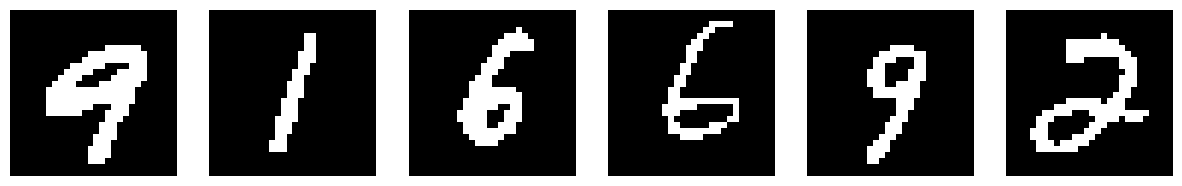

In [ ]:
# Visualize samples from the dataset
def visualize_samples(data_loader):
        data_iter = iter(data_loader)
        images, _ = next(data_iter)
        images = images[:6]  # Select 6 samples

        fig, axes = plt.subplots(1, 6, figsize=(15, 3))
        for i, img in enumerate(images):
            axes[i].imshow(img.view(28, 28), cmap="gray")
            axes[i].axis("off")
        plt.show()


print("Visualizing samples from the dataset:")
visualize_samples(train_loader)

# Part II

In [ ]:
class RBM:
    def __init__(self, input=None, n_visible=784, n_hidden=128, W=None, hbias=None, vbias=None, numpy_rng=None):
        self.n_visible = n_visible
        self.n_hidden = n_hidden

        if numpy_rng is None:
            numpy_rng = np.random.RandomState(1234)

        if W is None:
            a = 1. / n_visible
            W = numpy_rng.uniform(-a, a, size=(n_visible, n_hidden))

        if hbias is None:
            hbias = np.zeros(n_hidden)

        if vbias is None:
            vbias = np.zeros(n_visible)

        self.W = W
        self.hbias = hbias
        self.vbias = vbias
        self.numpy_rng = numpy_rng

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sample_h_given_v(self, v):
        h_mean = self.sigmoid(np.dot(v, self.W) + self.hbias)
        h_sample = self.numpy_rng.binomial(size=h_mean.shape, n=1, p=h_mean)
        return h_mean, h_sample

    def sample_v_given_h(self, h):
        v_mean = self.sigmoid(np.dot(h, self.W.T) + self.vbias)
        v_sample = self.numpy_rng.binomial(size=v_mean.shape, n=1, p=v_mean)
        return v_mean, v_sample

    def gibbs_hvh(self, h0_sample):
        v_mean, v_sample = self.sample_v_given_h(h0_sample)
        h_mean, h_sample = self.sample_h_given_v(v_sample)
        return v_mean, v_sample, h_mean, h_sample

    def contrastive_divergence(self, data, k=1, lr=0.1):
        ph_mean, ph_sample = self.sample_h_given_v(data)

        chain_start = ph_sample
        for step in range(k):
            if step == 0:
                nv_mean, nv_sample, nh_mean, nh_sample = self.gibbs_hvh(chain_start)
            else:
                nv_mean, nv_sample, nh_mean, nh_sample = self.gibbs_hvh(nh_sample)

        self.W += lr * (np.dot(data.T, ph_sample) - np.dot(nv_sample.T, nh_mean)) / len(data)
        self.vbias += lr * np.mean(data - nv_sample, axis=0)
        self.hbias += lr * np.mean(ph_sample - nh_mean, axis=0)

    def reconstruct(self, v):
        h = self.sigmoid(np.dot(v, self.W) + self.hbias)
        reconstructed_v = self.sigmoid(np.dot(h, self.W.T) + self.vbias)
        return reconstructed_v

    def save_model(self, file_path):
        with open(file_path, 'wb') as f:
            pickle.dump(self, f)

    @staticmethod
    def load_model(file_path):
        with open(file_path, 'rb') as f:
            return pickle.load(f)

In [ ]:
def train_rbm(train_loader, test_loader, n_visible, n_hidden, learning_rate, epochs, k):
      rbm = RBM(n_visible=n_visible, n_hidden=n_hidden)

      for epoch in range(epochs):
            for batch, _ in train_loader:
                batch = batch.view(-1, n_visible).numpy()
                rbm.contrastive_divergence(batch, k=k, lr=learning_rate)

            test_data = next(iter(test_loader))[0].view(-1, n_visible).numpy()
            reconstruction = rbm.reconstruct(test_data)
            loss = np.mean((test_data - reconstruction) ** 2)
            print(f"Epoch {epoch + 1}, k={k}: Reconstruction Loss = {loss:.4f}")

      return rbm

In [ ]:
# Parameters
num_visible = 28 * 28  # Number of visible units
num_hidden = 256       # Number of hidden units
learning_rate = 0.1
epochs = 15

print("Training RBM with k=1")
rbm_k1 = train_rbm(train_loader, test_loader, num_visible, num_hidden, learning_rate, epochs, k=1)
rbm_k1.save_model("rbm_k1.pkl")

print("Training RBM with k=5")
rbm_k5 = train_rbm(train_loader, test_loader, num_visible, num_hidden, learning_rate, epochs, k=5)
rbm_k5.save_model("rbm_k5.pkl")

print("Training RBM with k=10")
rbm_k10 = train_rbm(train_loader, test_loader, num_visible, num_hidden, learning_rate, epochs, k=10)
rbm_k10.save_model("rbm_k10.pkl")

Training RBM with k=1
Epoch 1, k=1: Reconstruction Loss = 0.0253
Epoch 2, k=1: Reconstruction Loss = 0.0203
Epoch 3, k=1: Reconstruction Loss = 0.0176
Epoch 4, k=1: Reconstruction Loss = 0.0158
Epoch 5, k=1: Reconstruction Loss = 0.0149
Epoch 6, k=1: Reconstruction Loss = 0.0142
Epoch 7, k=1: Reconstruction Loss = 0.0134
Epoch 8, k=1: Reconstruction Loss = 0.0130
Epoch 9, k=1: Reconstruction Loss = 0.0127
Epoch 10, k=1: Reconstruction Loss = 0.0126
Epoch 11, k=1: Reconstruction Loss = 0.0121
Epoch 12, k=1: Reconstruction Loss = 0.0120
Epoch 13, k=1: Reconstruction Loss = 0.0119
Epoch 14, k=1: Reconstruction Loss = 0.0116
Epoch 15, k=1: Reconstruction Loss = 0.0114
Training RBM with k=5
Epoch 1, k=5: Reconstruction Loss = 0.0258
Epoch 2, k=5: Reconstruction Loss = 0.0204
Epoch 3, k=5: Reconstruction Loss = 0.0180
Epoch 4, k=5: Reconstruction Loss = 0.0163
Epoch 5, k=5: Reconstruction Loss = 0.0154
Epoch 6, k=5: Reconstruction Loss = 0.0144
Epoch 7, k=5: Reconstruction Loss = 0.0137
Epoc

In [ ]:
# Generate samples from a trained RBM
def generate_samples(rbm, num_samples=6, num_gibbs_steps=100):
      random_visible = np.random.rand(num_samples, rbm.n_visible) > 0.5
      for _ in range(num_gibbs_steps):
          _, random_visible = rbm.sample_h_given_v(random_visible)
          _, random_visible = rbm.sample_v_given_h(random_visible)
      return random_visible

def visualize_generated_samples(generated_samples):
      fig, axes = plt.subplots(1, len(generated_samples), figsize=(15, 3))
      for i, sample in enumerate(generated_samples):
          axes[i].imshow(sample.reshape(28, 28), cmap="gray")
          axes[i].axis("off")
      plt.show()

Generating samples from RBM with k=1


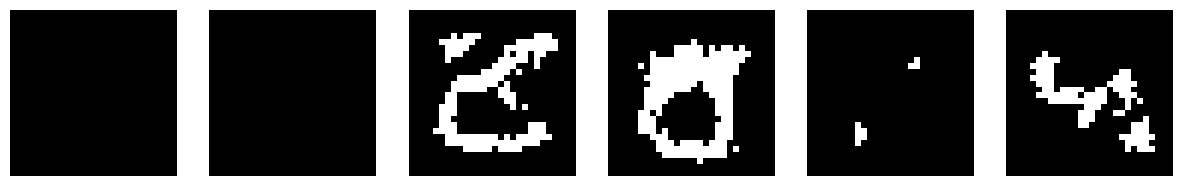

In [ ]:
print("Generating samples from RBM with k=1")
generated_samples_k1 = generate_samples(rbm_k1, num_samples=6, num_gibbs_steps=200)
visualize_generated_samples(generated_samples_k1)

Generating samples from RBM with k=5


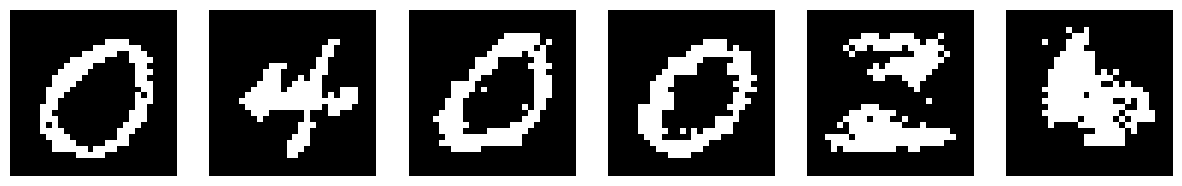

In [ ]:
print("Generating samples from RBM with k=5")
generated_samples_k5 = generate_samples(rbm_k5, num_samples=6, num_gibbs_steps=800)
visualize_generated_samples(generated_samples_k5)

Generating samples from RBM with k=10


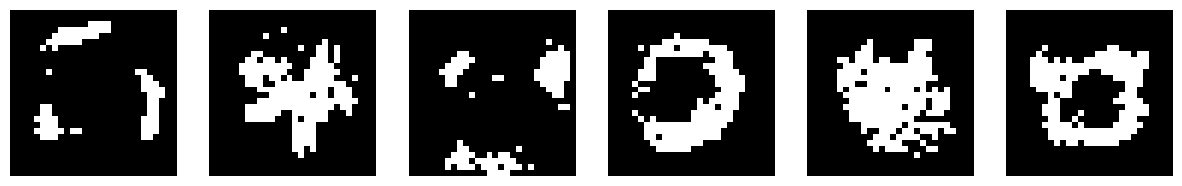

In [ ]:
print("Generating samples from RBM with k=10")
generated_samples_k10 = generate_samples(rbm_k10, num_samples=6, num_gibbs_steps=1000)
visualize_generated_samples(generated_samples_k10)

## Run if you want to load the model

Generating samples from RBM with k=1


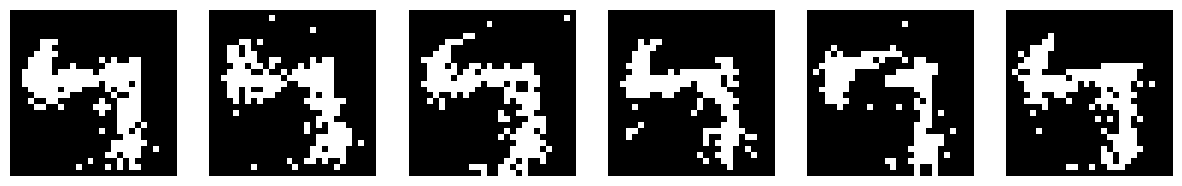

Generating samples from RBM with k=5


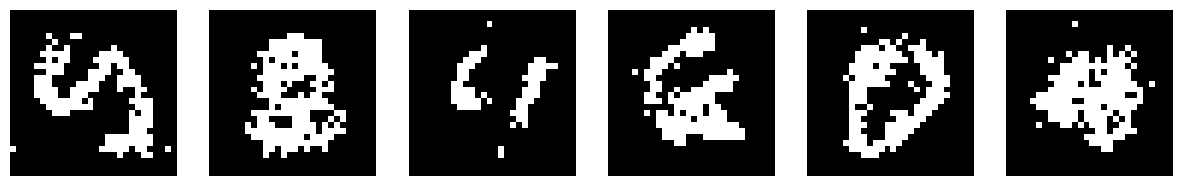

Generating samples from RBM with k=10


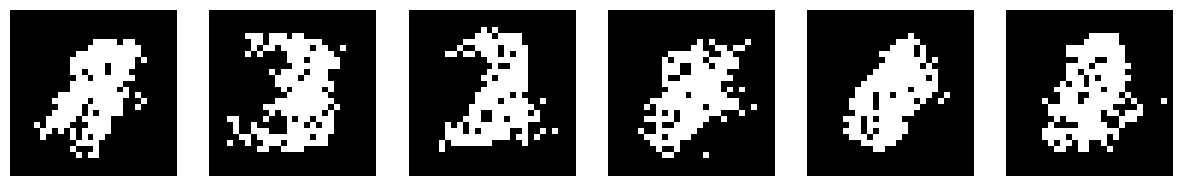

In [ ]:
print("Generating samples from RBM with k=1")
rbm_k1_loaded = RBM.load_model("rbm_k1.pkl")
generated_samples_k1 = generate_samples(rbm_k1_loaded, num_samples=6, num_gibbs_steps=500)
visualize_generated_samples(generated_samples_k1)

print("Generating samples from RBM with k=5")
rbm_k5_loaded = RBM.load_model("rbm_k5.pkl")
generated_samples_k5 = generate_samples(rbm_k5_loaded, num_samples=6, num_gibbs_steps=500)
visualize_generated_samples(generated_samples_k5)

print("Generating samples from RBM with k=10")
rbm_k10_loaded = RBM.load_model("rbm_k10.pkl")
generated_samples_k10 = generate_samples(rbm_k10_loaded, num_samples=6, num_gibbs_steps=500)
visualize_generated_samples(generated_samples_k10)

# Part III

In [ ]:
# Animate the MCMC improvement process
def animate_mcmc(rbm, num_samples=1, num_gibbs_steps=800, output_file="mcmc_animation.mp4"):
        random_visible = (np.random.rand(num_samples, rbm.n_visible) > 0.5).astype(float)
        fig, ax = plt.subplots(figsize=(5, 5))

        img = ax.imshow(random_visible[0].reshape(28, 28), cmap="gray", animated=True)
        ax.axis("off")

        def update(frame):
            nonlocal random_visible
            _, random_visible = rbm.sample_h_given_v(random_visible)
            _, random_visible = rbm.sample_v_given_h(random_visible)
            img.set_array((random_visible[0].reshape(28, 28) > 0.5).astype(float))
            return [img]

        writer = FFMpegWriter(fps=10, metadata=dict(artist="RBM Animation"), bitrate=1800)
        with writer.saving(fig, output_file, dpi=100):
            for frame in range(num_gibbs_steps):
                update(frame)
                writer.grab_frame()

Animating the MCMC process for RBM with k=5


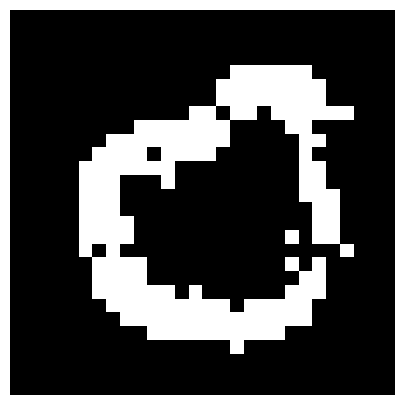

In [ ]:
print("Animating the MCMC process for RBM with k=5")
animate_mcmc(rbm_k5, output_file="mcmc_animation_k5.mp4")

# Part 4


In [ ]:
class ConditionalRBM:

    def __init__(self, n_visible=784, n_hidden=256, n_labels=10, numpy_rng=None):

        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.n_labels = n_labels

        if numpy_rng is None:
            numpy_rng = np.random.RandomState(1234)
        self.numpy_rng = numpy_rng

        # Weight matrix, and biases for hidden and visible units
        # W shape = (n_visible + n_labels, n_hidden)
        self.W = numpy_rng.uniform(
            low=-0.1, high=0.1, size=(n_visible + n_labels, n_hidden)
        )
        self.hbias = np.zeros(n_hidden, dtype=np.float32)
        self.vbias = np.zeros(n_visible + n_labels, dtype=np.float32)

    @staticmethod
    def sigmoid(x):

        return 1.0 / (1.0 + np.exp(-x))

    def sample_h_given_v(self, v):

        h_mean = self.sigmoid(np.dot(v, self.W) + self.hbias)
        h_sample = self.numpy_rng.binomial(n=1, p=h_mean, size=h_mean.shape)
        return h_mean, h_sample

    def sample_v_given_h(self, h, fixed_label=None):
        v_mean = self.sigmoid(np.dot(h, self.W.T) + self.vbias)
        # If we want to fix the label portion, override the last n_labels entries
        if fixed_label is not None:
            v_mean[:, -self.n_labels:] = fixed_label
        v_sample = self.numpy_rng.binomial(n=1, p=v_mean, size=v_mean.shape)
        return v_mean, v_sample

    def gibbs_hvh(self, h_sample_start, fixed_label=None):
        v_mean, v_sample = self.sample_v_given_h(h_sample_start, fixed_label=fixed_label)
        h_mean, h_sample = self.sample_h_given_v(v_sample)
        return v_mean, v_sample, h_mean, h_sample

    def contrastive_divergence(self, data, labels, k=1, lr=0.1):
        # Combine data and labels into a single visible vector
        v0 = np.hstack((data, labels))
        # Positive phase: sample hidden given v0
        ph_mean, ph_sample = self.sample_h_given_v(v0)

        # Start the chain from the positive hidden sample
        h_sample = ph_sample

        # Gibbs sampling (negative phase)
        for step in range(k):
            v_mean, v_sample, nh_mean, nh_sample = self.gibbs_hvh(
                h_sample, fixed_label=labels
            )
            h_sample = nh_sample  # continue chaining


        self.W += lr * (
            np.dot(v0.T, ph_sample) - np.dot(v_sample.T, nh_mean)
        ) / len(data)

        self.vbias += lr * np.mean((v0 - v_sample), axis=0)
        self.hbias += lr * np.mean((ph_sample - nh_mean), axis=0)

    def reconstruct(self, v):
        h = self.sigmoid(np.dot(v, self.W) + self.hbias)
        return self.sigmoid(np.dot(h, self.W.T) + self.vbias)

    def generate(self, label, num_samples=1, num_gibbs_steps=100):

        label_one_hot = np.zeros((num_samples, self.n_labels))
        label = np.array(label, ndmin=1)  # ensure it's an array
        label_one_hot[np.arange(num_samples), label] = 1

        # Start with random visible units, and attach the chosen labels
        random_vis = self.numpy_rng.rand(num_samples, self.n_visible)
        v = np.hstack((random_vis, label_one_hot))

        # Run Gibbs sampling
        for _ in range(num_gibbs_steps):
            _, h_sample = self.sample_h_given_v(v)
            _, v = self.sample_v_given_h(h_sample, fixed_label=label_one_hot)

        # Return only the image portion, without the labels
        return v[:, :-self.n_labels]

    def save_model(self, file_path):
        with open(file_path, 'wb') as f:
            pickle.dump(self, f)

    @staticmethod
    def load_model(file_path):
        with open(file_path, 'rb') as f:
            return pickle.load(f)

In [ ]:
n_visible = 28 * 28
n_hidden = 256
n_labels = 10
learning_rate = 0.1
epochs = 15

crbm = ConditionalRBM(n_visible=n_visible, n_hidden=n_hidden, n_labels=n_labels)

# Training CRBM
for epoch in range(epochs):
      for batch, labels in train_loader:
           batch = batch.view(-1, n_visible).numpy()
           labels = np.eye(n_labels)[labels.numpy()]
           crbm.contrastive_divergence(batch, labels, k=5, lr=learning_rate)

      test_data, test_labels = next(iter(test_loader))
      test_data = test_data.view(-1, n_visible).numpy()
      test_labels = np.eye(n_labels)[test_labels.numpy()]
      reconstruction = crbm.reconstruct(np.hstack((test_data, test_labels)))
      loss = np.mean((test_data - reconstruction[:, :-n_labels]) ** 2)
      print(f"Epoch {epoch + 1}: Reconstruction Loss = {loss:.4f}")

crbm.save_model("crbm.pkl")

Epoch 1: Reconstruction Loss = 0.0242
Epoch 2: Reconstruction Loss = 0.0201
Epoch 3: Reconstruction Loss = 0.0174
Epoch 4: Reconstruction Loss = 0.0159
Epoch 5: Reconstruction Loss = 0.0146
Epoch 6: Reconstruction Loss = 0.0139
Epoch 7: Reconstruction Loss = 0.0134
Epoch 8: Reconstruction Loss = 0.0129
Epoch 9: Reconstruction Loss = 0.0123
Epoch 10: Reconstruction Loss = 0.0122
Epoch 11: Reconstruction Loss = 0.0118
Epoch 12: Reconstruction Loss = 0.0116
Epoch 13: Reconstruction Loss = 0.0115
Epoch 14: Reconstruction Loss = 0.0111
Epoch 15: Reconstruction Loss = 0.0112


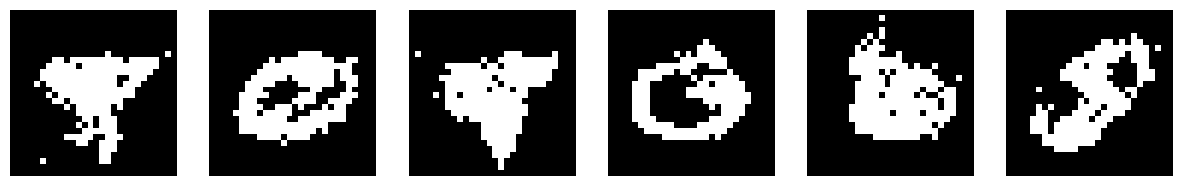

In [ ]:
# Generate samples for label '2'
num_gen = 6
generated_images = crbm.generate(label=[6] * num_gen, num_samples=num_gen, num_gibbs_steps=800)

# Visualize generated samples
fig, axes = plt.subplots(1, num_gen, figsize=(15, 3))
for i, sample in enumerate(generated_images):
     axes[i].imshow(sample.reshape(28, 28), cmap="gray")
     axes[i].axis("off")
plt.show()